Saving marketing_campaign.csv to marketing_campaign (41).csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 n

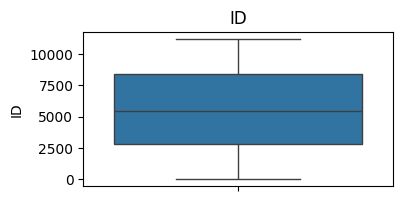

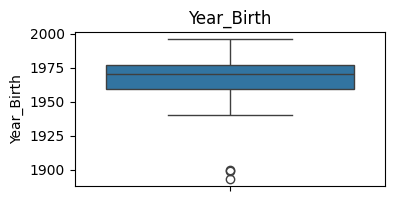

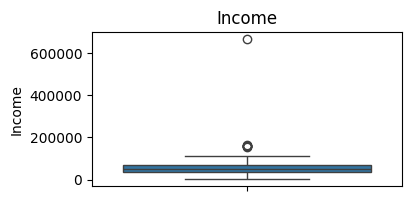

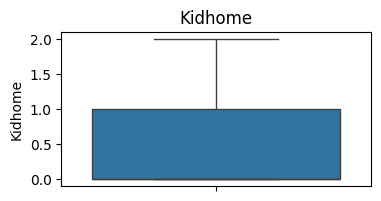

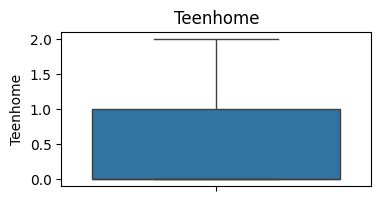

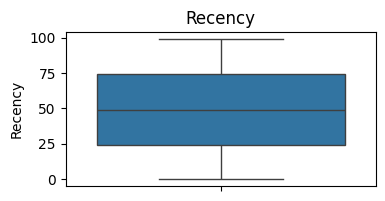

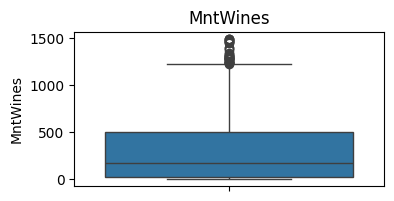

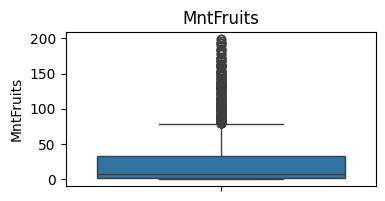

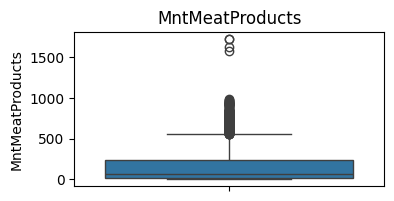

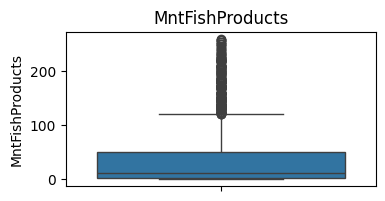

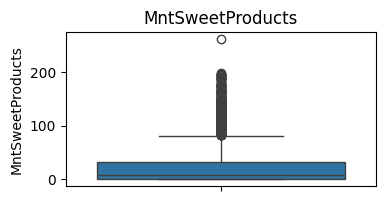

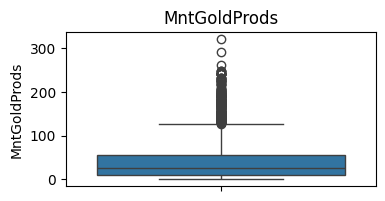

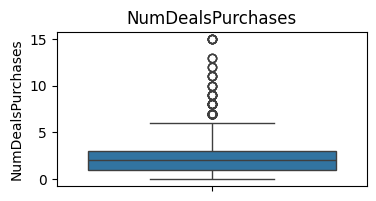

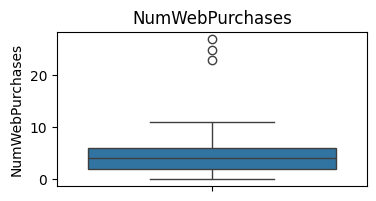

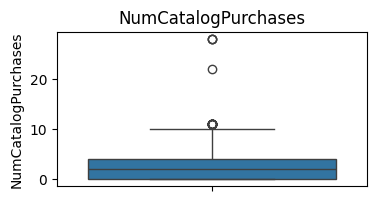

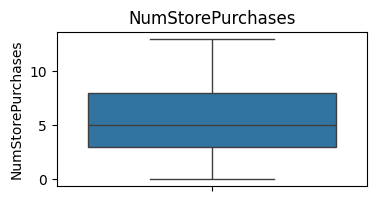

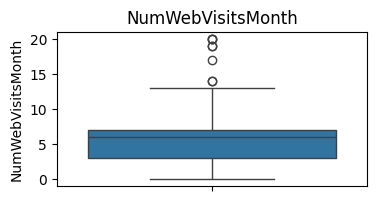

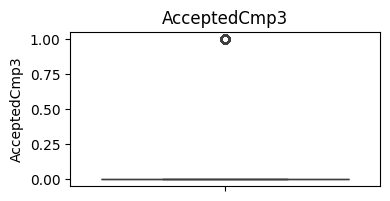

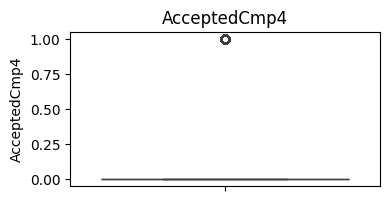

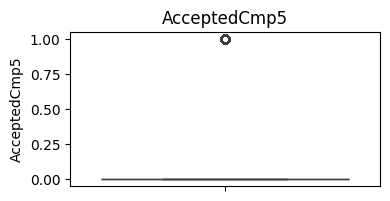

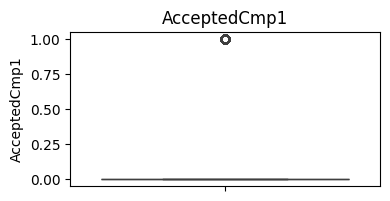

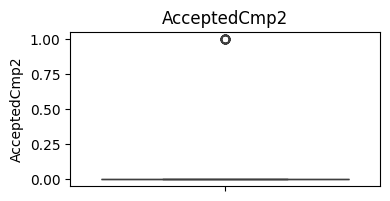

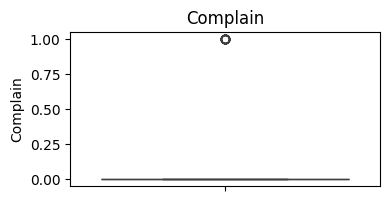

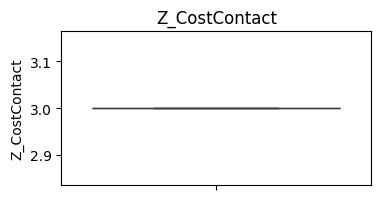

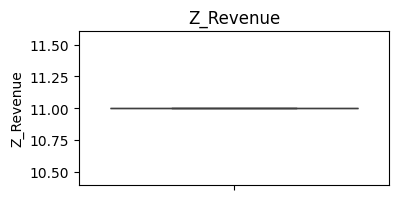

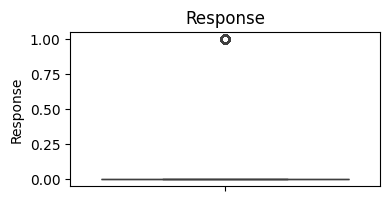

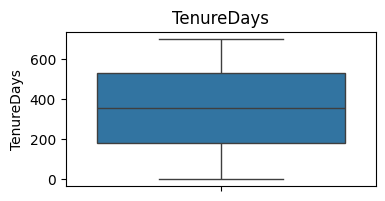

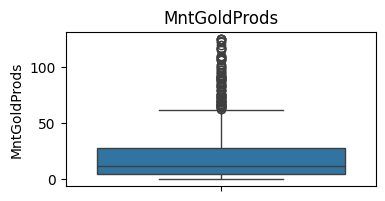

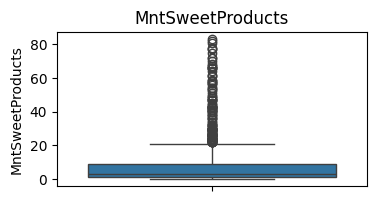

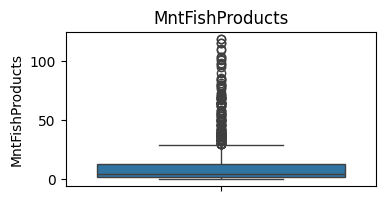

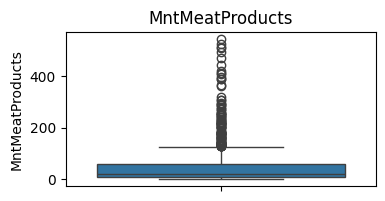

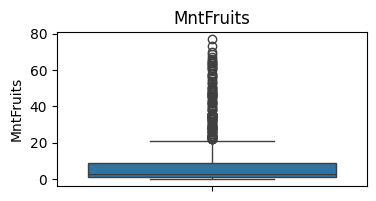

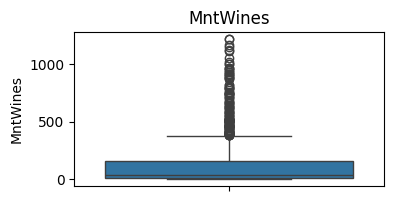

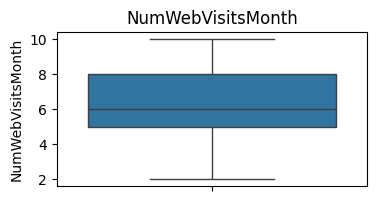

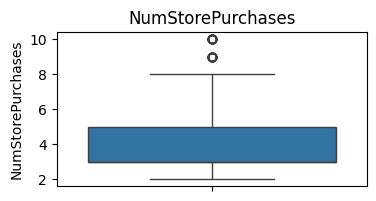

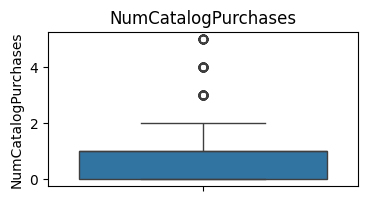

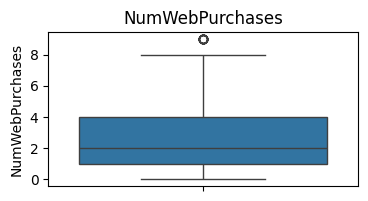

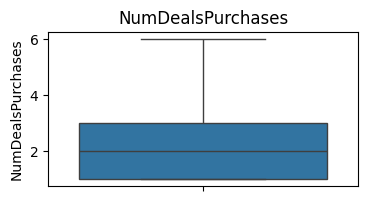

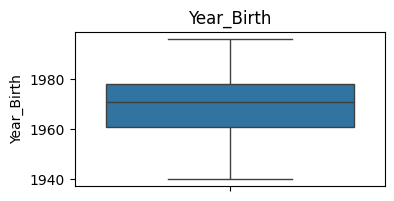

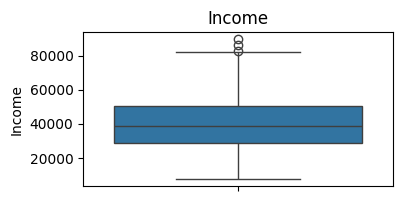

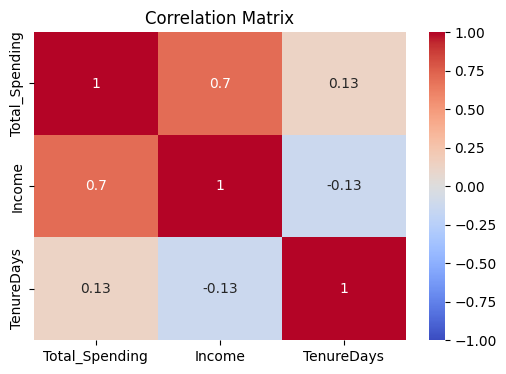

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()
import pandas as pd
df = pd.read_csv('marketing_campaign.csv', sep=';')
df.shape
df.info()
df.isnull().sum()

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
df['TenureDays'] = (df['Dt_Customer'].max() - df['Dt_Customer']).dt.days

df = df.dropna(subset=['Income'])
df.isnull().sum()

# Check Outlier cho tất cả các cột numeric
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
import matplotlib.pyplot as plt
import seaborn as sns
for col in num_cols:
  plt.figure(figsize=(4,2))
  sns.boxplot(y=df[col])
  plt.title(col)
  plt.show()

# Xử outlier cho cột Year Birth (Cột này thường lỗi do nhập liệu nên xóa những giá trị vô lý)
df = df.loc[(df['Year_Birth'] <= 2000) & (df['Year_Birth'] >= 1920)]
# Xử outlier cho cột Income (Cột này khó xử vì thường chứa lỗi nhập liệu, vừa có thể chứa khách VIP thật) --> Dùng IQR
Q1 = df['Income'].quantile(0.25)
Q3 = df['Income'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df.loc[(df['Income'] >= lower_bound) & (df['Income'] <= upper_bound)]
# Xử outlier cho nhóm Mnt... - chi tiêu (Cột này cũng khó vì có thể chứa lỗi nhập liệu, khách chịu chi, khách mua sỉ) --> Dùng IQR vì chỉ phân tích hành vi trung bình, không cần giữ VIP
outlier_idx = set()
for col in ['MntGoldProds', 'MntSweetProducts', 'MntFishProducts', 'MntMeatProducts', 'MntFruits', 'MntWines']:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  idx = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
  outlier_idx.update(idx)
df = df.drop(index=outlier_idx)
df.reset_index(drop=True, inplace=True)
# Xử outlier cho nhóm Num - số lần mua hàng hoặc tương tác (Cột này cũng khó vì có thể do lỗi nhập liệu, khách tương tác tích cực) --> Dùng IQR luôn cho đồng nhất với nhóm chi tiêu
outlier_idx2 = set()
for col in ['NumWebVisitsMonth', 'NumStorePurchases', 'NumCatalogPurchases', 'NumWebPurchases', 'NumDealsPurchases']:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = max(0, Q1 - 1.5 * IQR) # Vì Lower bound IQR có thể âm (vô nghĩa với biến đếm) nên kẹp về 0 cho an toàn
  upper_bound = Q3 + 1.5 * IQR
  idx = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
  outlier_idx2.update(idx)
df = df.drop(index=outlier_idx2)
df.reset_index(drop=True, inplace=True)

# Vẽ boxplot check lại lần nữa các outlier đã được xử chưa
for col in ['MntGoldProds', 'MntSweetProducts', 'MntFishProducts', 'MntMeatProducts', 'MntFruits', 'MntWines', 'NumWebVisitsMonth', 'NumStorePurchases', 'NumCatalogPurchases', 'NumWebPurchases', 'NumDealsPurchases', 'Year_Birth', 'Income']:
  plt.figure(figsize=(4,2))
  sns.boxplot(y=df[col])
  plt.title(col)
  plt.show()

# Phân nhóm
df['Total_Spending'] = df[['MntGoldProds', 'MntSweetProducts', 'MntFishProducts', 'MntMeatProducts', 'MntFruits', 'MntWines']].sum(axis=1)
df['Income_Segment'] = pd.qcut(df['Income'], q = 3, labels=['Low Income', 'Normal Income', 'High Income'], duplicates='drop')
df['Spending_Segment'] = pd.qcut(df['Total_Spending'], q = 3, labels=['Low Spending', 'Normal Spending', 'High Spending'], duplicates='drop')

# Hoàn thiện
num_cols = ['Total_Spending', 'Income', 'TenureDays']
corr = df[num_cols].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.title("Correlation Matrix")
plt.show()

# Xuất data
from google.colab import files
df.to_csv('marketing_campaign_clean.csv', index = False)
files.download('marketing_campaign_clean.csv')